# Examples of running IHPF 

1. Download the scRNA-seq datasets in h5ad format and put in the folder Data/ 

Creating a smaller sample of 10Xmouse, does not work as the sub-sampled cells does not represent the distribution of original samples, making these cells not usable for IHPF. 


In [80]:
import IHPF
import INMF 
import schpf
from sklearn.decomposition import PCA

In [48]:
from scipy.sparse import coo_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData

In [178]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc']
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    print(adata)

AnnData object with n_obs × n_vars = 9530 × 13130
    obs: 'actual', 'batch', 'IHPF_kmeans_normalised', 'HPF_kmeans_normalised', 'INMF_kmeans_normalised', 'IPCA_kmeans_normalised', 'INMF_2_kmeans_normalised'
    obsm: 'HPF', 'IHPF', 'INMF', 'INMF_2', 'IPCA'
    varm: 'HPF', 'IHPF', 'INMF', 'INMF_2'
AnnData object with n_obs × n_vars = 15921 × 5057
    obs: 'actual', 'batch', 'IHPF_kmeans_normalised', 'HPF_kmeans_normalised', 'INMF_kmeans_normalised', 'IPCA_kmeans_normalised', 'INMF_10_kmeans_normalised', 'HPF_10_kmeans_normalised'
    obsm: 'HPF', 'HPF_10', 'IHPF', 'INMF', 'INMF_10', 'IPCA'
    varm: 'HPF', 'HPF_10', 'IHPF', 'INMF', 'INMF_10'
AnnData object with n_obs × n_vars = 41927 × 8234
    obs: 'actual', 'batch', 'IHPF_kmeans_normalised', 'HPF_kmeans_normalised', 'INMF_kmeans_normalised', 'IPCA_kmeans_normalised', 'INMF_7_kmeans_normalised'
    obsm: 'HPF', 'IHPF', 'INMF', 'INMF_7', 'IPCA'
    varm: 'HPF', 'IHPF', 'INMF', 'INMF_7'


In [129]:
adata.obs

,cell_type,condition,mt_frac,n_counts,n_genes,percent_mito,study
index,,,,,,,
AAACATACCAAGCT-1-stimulated-0,NK cells,stimulated,0.0,1158.0,589,NaN,Kang et al
AAACATACCCCTAC-1-stimulated-0,Dendritic cells,stimulated,0.0,1722.0,795,NaN,Kang et al
AAACATACCCGTAA-1-stimulated-0,CD4 T cells,stimulated,0.0,1360.0,585,NaN,Kang et al
AAACATACCCTCGT-1-stimulated-0,B cells,stimulated,0.0,1438.0,732,NaN,Kang et al
AAACATACGAGGTG-1-stimulated-0,CD4 T cells,stimulated,0.0,1233.0,546,NaN,Kang et al
...,...,...,...,...,...,...,...
TTTGACTGGCGGAA-1-control-0,CD8 T cells,control,0.0,2503.0,821,NaN,Kang et al
TTTGACTGTCGTAG-1-control-0,CD14+ Monocytes,control,0.0,3696.0,1101,NaN,Kang et al
TTTGACTGTTACCT-1-control-0,CD14+ Monocytes,control,0.0,2108.0,629,NaN,Kang et al


In [131]:
adata.obs.condition.value_counts()

stimulated    7772
control       7121
Name: condition, dtype: int64

In [86]:
adata.obs.batch.value_counts()

1    32897
0    29217
Name: batch, dtype: int64

In [173]:
adata.var_names

Index(['LINC00115', 'NOC2L', 'HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'SDF4',
       'CPSF3L', 'GLTPD1', 'MXRA8',
       ...
       'FAM207A', 'ADARB1', 'POFUT2', 'COL18A1', 'SLC19A1', 'COL6A2', 'PCNT',
       'DIP2A', 'S100B', 'PRMT2'],
      dtype='object', name='index', length=7000)

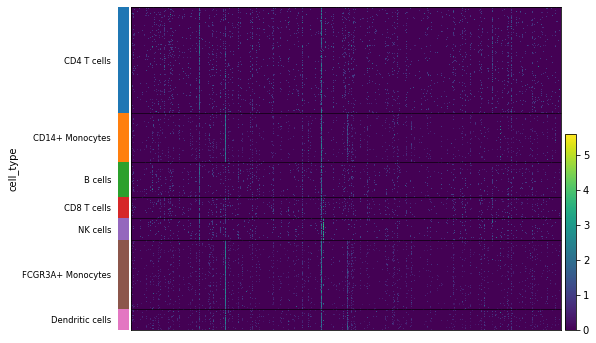

In [176]:
sc.pl.heatmap(adata,adata.var_names[:2000],groupby='cell_type')

In [179]:
batch_labels = 'batch'
cell_labels = 'actual'
datasets = ['10Xmouse','humanpancreas','10Xpbmc']

## IHPF 

In [180]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    adataobs = adata.obs.copy()
    no_cell_types = len(adataobs[cell_labels].unique())
    adataobs.reset_index(inplace=True)
    Xlist = list()
    for i,df in adataobs.groupby(batch_labels):
        batchidx = df.index
        Xlist.append(coo_matrix(adata.X[batchidx,:]))
    model = IHPF.scIHPF(no_cell_types,max_iter=500)
    model.fit(Xlist)
    adata.obsm['IHPF'] = np.concatenate(model.cell_scores(),axis=0)
    adata.varm['IHPF'] = model.shared_gene_scores()
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['IHPF']))
    adata.obs['IHPF_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['IHPF_max'] = np.argmax(adata.obsm['IHPF'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))
    

Clipping dp: was [7.050768545013852e-06, 8.257898116426077e-06, 7.804119377397e-06] now [5.125247407704592e-07, 4.083773528691381e-07, 4.393301496747881e-07]
[Iter.    0]  loss:89.469641  pct:100.000000000
[Iter.   10]  loss:6.578422  pct:-92.647313534
[Iter.   20]  loss:6.502860  pct:-1.148629457
[Iter.   30]  loss:6.401582  pct:-1.557451612
[Iter.   40]  loss:6.376951  pct:-0.384760228
[Iter.   50]  loss:6.361311  pct:-0.245263046
[Iter.   60]  loss:6.334075  pct:-0.428142719
[Iter.   70]  loss:6.313144  pct:-0.330453219
[Iter.   80]  loss:6.303784  pct:-0.148257899
[Iter.   90]  loss:6.298786  pct:-0.079294231
[Iter.  100]  loss:6.295485  pct:-0.052393589
[Iter.  110]  loss:6.293180  pct:-0.036624747
[Iter.  120]  loss:6.291370  pct:-0.028763150
[Iter.  130]  loss:6.289859  pct:-0.024010438
[Iter.  140]  loss:6.288721  pct:-0.018093858
[Iter.  150]  loss:6.287863  pct:-0.013647847
[Iter.  160]  loss:6.287185  pct:-0.010783585
[Iter.  170]  loss:6.286649  pct:-0.008515064
[Iter.  180

## INMF 

In [181]:
from INMF import INMF

In [182]:
class scINMF:
    def __init__(self, k, alpha=1, **kwargs):
        np.random.seed(0)
        self.n_components = k
        self.method = INMF(
            n_components=self.n_components, solver="mu", alpha=alpha, **kwargs
        )

    def fit(self, X):
        self.data = X
        (
            self.cell_scores,
            self.shared_gene_scores,
            self.dataset_gene_scores,
        ) = self.method.fit_transform(self.data)


In [183]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    adataobs = adata.obs.copy()
    no_cell_types = len(adataobs[cell_labels].unique())
    adataobs.reset_index(inplace=True)
    Xlist = list()
    for i,df in adataobs.groupby(batch_labels):
        batchidx = df.index
        Xlist.append(coo_matrix(adata.X[batchidx,:]))
    model = scINMF(no_cell_types,alpha=1,max_iter=500)
    model.fit(Xlist)
    adata.obsm['INMF'] = np.concatenate(model.cell_scores,axis=0)
    adata.varm['INMF'] = model.shared_gene_scores.transpose()
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['INMF']))
    adata.obs['INMF_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['INMF_max'] = np.argmax(adata.obsm['INMF'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

Reconstruction error 75028.04665185406
Reconstruction error 1120212.068773359
Reconstruction error 39113.86003364466


## HPF

In [197]:
from schpf import scHPF
from scipy.sparse import vstack

In [198]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    adataobs = adata.obs.copy()
    no_cell_types = len(adataobs[cell_labels].unique())
    adataobs.reset_index(inplace=True)
    Xlist = list()
    for i,df in adataobs.groupby(batch_labels):
        batchidx = df.index
        Xlist.append(coo_matrix(adata.X[batchidx,:]))
    model = scHPF(no_cell_types,max_iter=500)
    model.fit(vstack(Xlist))
    adata.obsm['HPF'] = model.cell_score()
    adata.varm['HPF'] = model.gene_score()
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['HPF']))
    adata.obs['HPF_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['HPF_max'] = np.argmax(adata.obsm['HPF'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

[Iter.    0]  loss:28.943476  pct:100.000000000
[Iter.   10]  loss:3.781775  pct:-86.933930773
[Iter.   20]  loss:2.796690  pct:-26.048212222
[Iter.   30]  loss:2.789416  pct:-0.260105204
[Iter.   40]  loss:2.788082  pct:-0.047797679
[Iter.   50]  loss:2.787563  pct:-0.018611809
[Iter.   60]  loss:2.787469  pct:-0.003395784
[Iter.   70]  loss:2.787374  pct:-0.003407014
[Iter.   80]  loss:2.787326  pct:-0.001720420
[Iter.   90]  loss:2.787285  pct:-0.001451991
[Iter.  100]  loss:2.787254  pct:-0.001118041
[Iter.  110]  loss:2.787246  pct:-0.000276248
[Iter.  120]  loss:2.787235  pct:-0.000406275
converged
[Iter.    0]  loss:706.698339  pct:100.000000000
[Iter.   10]  loss:26.197092  pct:-96.293030541
[Iter.   20]  loss:21.431471  pct:-18.191409966
[Iter.   30]  loss:20.557083  pct:-4.079928049
[Iter.   40]  loss:20.154442  pct:-1.958647219
[Iter.   50]  loss:20.014587  pct:-0.693916318
[Iter.   60]  loss:19.933371  pct:-0.405784283
[Iter.   70]  loss:19.892647  pct:-0.204300581
[Iter.  

## PCA

In [186]:
class scPCA:
    def __init__(self, k):
        from sklearn.decomposition import TruncatedSVD

        np.random.seed(0)
        self.n_components = k
        self.method = TruncatedSVD(n_components=self.n_components)

    def fit(self, X):
        self.data = X
        self.method.fit(self.data)
        self.cell_score = self.method.transform(self.data)
        self.gene_score = self.method.components_.transpose()

In [187]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    adataobs = adata.obs.copy()
    no_cell_types = len(adataobs[cell_labels].unique())
    adataobs.reset_index(inplace=True)
    Xlist = list()
    for i,df in adataobs.groupby(batch_labels):
        batchidx = df.index
        Xlist.append(coo_matrix(adata.X[batchidx,:]))
    model = scPCA(no_cell_types)
    model.fit(vstack(Xlist))
    adata.obsm['PCA'] = model.cell_score
    adata.varm['PCA'] = model.gene_score
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['PCA']))
    adata.obs['PCA_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['PCA_max'] = np.argmax(adata.obsm['PCA'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

In [188]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))

In [189]:
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [194]:
batchputriy = dict()
actualputriy = dict()

for dataset in datasets:
    batch = dict()
    actual = dict()
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    for method in ['IHPF','INMF','HPF','PCA']:
        le = preprocessing.LabelEncoder()
        batchlabel = le.fit_transform(adata.obs[batch_labels])
        le = preprocessing.LabelEncoder()
        actuallabel = le.fit_transform(adata.obs[cell_labels])
        no_cell_types = len(adataobs[cell_labels].unique())
        batch[method] = np.sum(np.max(confusion_matrix(batchlabel,adata.obs['{}_kmeans_normalised'.format(method)]),axis=1)) / len(adata.obs[cell_labels])
        actual[method] = np.sum(np.max(confusion_matrix(actuallabel,adata.obs['{}_kmeans_normalised'.format(method)]),axis=1)) / len(adata.obs[cell_labels])
    actual['batch'] =  np.sum(np.max(confusion_matrix(actuallabel,batchlabel),axis=1)) / len(adata.obs[cell_labels])
    batchputriy[dataset] = batch
    actualputriy[dataset] = actual

In [195]:
np.round(pd.DataFrame(actualputriy),3)

,10Xmouse,humanpancreas,10Xpbmc
IHPF,0.997,0.437,0.547
INMF,0.806,0.431,0.486
HPF,0.697,0.691,0.797
PCA,0.765,0.385,0.797
batch,0.644,0.538,0.797


In [201]:
batchAMI = dict()
actualAMI = dict()

for dataset in datasets:
    batch = dict()
    actual = dict()
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    for method in ['IHPF','INMF','HPF','PCA']:
        batch[method] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs['{}_kmeans_normalised'.format(method)])
        actual[method] = adjusted_mutual_info_score(adata.obs[cell_labels],adata.obs['{}_kmeans_normalised'.format(method)])
    batch['actual'] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs[cell_labels])
    actual['batch'] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs[cell_labels])
    batchAMI[dataset] = batch
    actualAMI[dataset] = actual

10Xmouse (9530, 13130)
humanpancreas (15921, 5057)
10Xpbmc (41927, 8234)


In [202]:
np.round(pd.DataFrame(actualAMI),3)

,10Xmouse,humanpancreas,10Xpbmc
IHPF,0.976,0.276,0.478
INMF,0.125,0.200,0.172
HPF,0.256,0.139,0.762
PCA,0.287,0.211,0.799
batch,0.498,0.032,0.810
